# GNNs

## mass into account

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GeneralConv, GENConv
from torch_geometric.nn.models import MLP
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from datagen import generate_dataset, generate_dataset_nbodies, generate_dataset_1gal, generate_scene_1gal
from tqdm import tqdm



def fully_connected(input_dim, hidden_dim, output_dim, num_layers):
    layers = []
    # Add hidden layers
    for _ in range(num_layers):
        layers.append(torch.nn.Linear(input_dim, hidden_dim))
        layers.append(torch.nn.ReLU())
        input_dim = hidden_dim
    # Add output layer
    layers.append(torch.nn.Linear(hidden_dim, output_dim))
    return torch.nn.Sequential(*layers)

# Function to create edge weights based on mass difference
def create_edge_attributes_based_on_mass_and_dist(data):
    row, col = data.edge_index  # Get indices of connected nodes
    # Get masses for each node in the connection
    pos_row = data.x[row][:, :3]
    pos_col = data.x[col][:, :3]
    distance = torch.norm(pos_row - pos_col, dim=1)  # Calculate distance between nodes
    mass_row = data.x[row][:, -1]
    mass_col = data.x[col][:, -1]
    mass_prod = mass_row * mass_col  # Multiply masses
    data.edge_attr = torch.stack([mass_prod, distance], dim=1)  # Concatenate edge attributes
    
    return data

class ParticleGNN(torch.nn.Module):
    def __init__(self, input_dim=9, edge_dim=2,  node_enc_hidden = [128, 256], edge_enc_hidden = [128, 256], dec_hidden = [256, 128], gnn_dim=256, message_passing_steps=5, agg='mean', output_dim=3):
        super(ParticleGNN, self).__init__()
        # Encoder for initial node features
        self.node_encoder = MLP([input_dim] + node_enc_hidden + [gnn_dim])
        self.edge_encoder = MLP([edge_dim] + edge_enc_hidden + [gnn_dim])
        # GeneralConv layers for message passing
        self.gnns = []
        for i in range(message_passing_steps):
            gnn = GENConv(in_channels=gnn_dim, out_channels=gnn_dim, aggr=agg, edge_dim=gnn_dim)
            setattr(self, f'gnn_{i}', gnn)
            self.gnns.append(gnn)
        
        # Decoder to transform final node features to output
        self.decoder = MLP([gnn_dim] + dec_hidden + [output_dim])

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr  # Use edge_attr instead of edge_weight
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        
        for gnn in self.gnns:
            x = F.relu(gnn(x, edge_index, edge_attr=edge_attr))  # Pass edge_attr to GeneralConv
        
        x = self.decoder(x)
        return x



# Function to convert particles to a torch_geometric Data object
def transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius):
    # Extract features for each particle: [x, y, z, vx, vy, vz, mass]

    
    # Create edges based on radius
    edge_index = radius_graph(positions, r=radius)
    # for every node, connect it to top 2 biggest nodes
    '''
    biggest_nodes_index = torch.argsort(features[:, -1], descending=True)[:2]
    for i in range(features.shape[0]):
        if i not in biggest_nodes_index:
            edge_index = torch.cat((edge_index, torch.tensor([[i, biggest_nodes_index[0]], [i, biggest_nodes_index[1]]], dtype=torch.long)), 1)
            edge_index = torch.cat((edge_index, torch.tensor([[biggest_nodes_index[0], i], [biggest_nodes_index[1], i]], dtype=torch.long)), 1)
    '''


    
    # Create data object
    graph_data = Data(x=features, edge_index=edge_index)
    
    # Add edge weights based on mass
    graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
    return graph_data





In [ ]:
def euclidean_distance(a, b):
    return torch.sqrt(torch.sum((a - b)**2, dim=-1) + 1e-12)

def mean_distance(a, b):
    return torch.mean(euclidean_distance(a, b))

In [3]:
import torch
def generate_graph_dataset(data, radius):
    graphs = []
    for i in tqdm(range(len(data))):
        masses = torch.tensor(data[i]['masses']).unsqueeze(-1)
        positions = torch.tensor(data[i]['pos'])
        velocities = torch.tensor(data[i]['vel'])
        Gs = torch.ones_like(masses) 
        softening = torch.ones_like(masses) * 0.1
        features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
        graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius)
        graph_data.y = torch.tensor(data[i]['acc'])
        graphs.append(graph_data)
    return graphs

In [4]:
# Initialize model and optimizer
import os
model = ParticleGNN()
# load model weights
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)
#model.load_state_dict(torch.load('./models/'+sorted(os.listdir('models'), key=lambda x: int(x.split('.')[0].split('_')[-1]))[-1], map_location=torch.device(device)))


In [13]:
import gc
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

ROUNDS = 50
EPOCHS = 4
SCENES = 30 
WINDOW_SIZE = 0
N_BODIES = 100
BATCH_SIZE = 16
RADIUS = 1.0
CHECKPOINT = 5

try:
    last_model_id = sorted([int(x.split('.')[0].split('_')[-1]) for x in os.listdir('models')])[-1]
    model.load_state_dict(torch.load(f'./models/particle_gnn_{last_model_id}.pth', map_location=torch.device(device)))
    print(f'Loaded model from ./models/particle_gnn_{last_model_id}.pth')
    last_model_id += 1
except:
    print('No model found, training from scratch')
    last_model_id = 0

# Training loop
model.train()
for r in range(ROUNDS):
    print(f'--- Round {r} ---')
    data = generate_dataset_1gal(n_scenes=SCENES, window_size=WINDOW_SIZE, particles=N_BODIES),
    print('Converting to graphs...')
    graphs = generate_graph_dataset(data[0], RADIUS)
    dataloader = DataLoader(graphs, batch_size=BATCH_SIZE)
    print('Training...')
    for epoch in range(EPOCHS):
        epoch_losses = []
        print(f'Epoch {epoch+1}')
        for data in tqdm(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = mean_distance(out, data.y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            del data
            torch.cuda.empty_cache()
            #torch.mps.empty_cache()
        print(f'Epoch {epoch+1}, Loss: {torch.tensor(epoch_losses).mean()}')
    del graphs, dataloader
    torch.cuda.empty_cache()
    #torch.mps.empty_cache()
    gc.collect()
    if (r+1) % CHECKPOINT == 0:
        print('Saving model...')
        torch.save(model.state_dict(), f'./models/particle_gnn_{last_model_id}.pth')
        last_model_id += 1
    







Loaded model from ./models/particle_gnn_16.pth
--- Round 0 ---
Generating dataset with 30 scenes...


100%|██████████| 30/30 [00:57<00:00,  1.90s/it]


Converting to graphs...


100%|██████████| 29280/29280 [00:28<00:00, 1010.66it/s]


Training...
Epoch 1


100%|██████████| 1830/1830 [00:52<00:00, 34.68it/s]


Epoch 1, Loss: 0.1779785305261612
Epoch 2


100%|██████████| 1830/1830 [00:52<00:00, 35.18it/s]


Epoch 2, Loss: 0.1690286248922348
Epoch 3


100%|██████████| 1830/1830 [00:51<00:00, 35.44it/s]


Epoch 3, Loss: 0.16498097777366638
Epoch 4


100%|██████████| 1830/1830 [00:51<00:00, 35.43it/s]


Epoch 4, Loss: 0.1622166633605957
--- Round 1 ---
Generating dataset with 30 scenes...


100%|██████████| 30/30 [00:53<00:00,  1.77s/it]


Converting to graphs...


100%|██████████| 29280/29280 [00:27<00:00, 1052.45it/s]


Training...
Epoch 1


100%|██████████| 1830/1830 [00:52<00:00, 35.02it/s]


Epoch 1, Loss: 0.17125041782855988
Epoch 2


100%|██████████| 1830/1830 [00:51<00:00, 35.40it/s]


Epoch 2, Loss: 0.16290202736854553
Epoch 3


100%|██████████| 1830/1830 [00:51<00:00, 35.45it/s]


Epoch 3, Loss: 0.15922944247722626
Epoch 4


100%|██████████| 1830/1830 [00:51<00:00, 35.20it/s]


Epoch 4, Loss: 0.15668727457523346
--- Round 2 ---
Generating dataset with 30 scenes...


100%|██████████| 30/30 [00:52<00:00,  1.76s/it]


Converting to graphs...


100%|██████████| 29280/29280 [00:27<00:00, 1074.59it/s]


Training...
Epoch 1


100%|██████████| 1830/1830 [00:52<00:00, 34.84it/s]


Epoch 1, Loss: 0.16750700771808624
Epoch 2


100%|██████████| 1830/1830 [00:51<00:00, 35.23it/s]


Epoch 2, Loss: 0.15911193192005157
Epoch 3


100%|██████████| 1830/1830 [00:51<00:00, 35.35it/s]


Epoch 3, Loss: 0.15540242195129395
Epoch 4


100%|██████████| 1830/1830 [00:51<00:00, 35.38it/s]


Epoch 4, Loss: 0.15283749997615814
--- Round 3 ---
Generating dataset with 30 scenes...


100%|██████████| 30/30 [00:53<00:00,  1.77s/it]


Converting to graphs...


100%|██████████| 29280/29280 [00:27<00:00, 1073.12it/s]


Training...
Epoch 1


100%|██████████| 1830/1830 [00:52<00:00, 34.82it/s]


Epoch 1, Loss: 0.17742513120174408
Epoch 2


100%|██████████| 1830/1830 [00:52<00:00, 35.17it/s]


Epoch 2, Loss: 0.16891926527023315
Epoch 3


100%|██████████| 1830/1830 [00:51<00:00, 35.38it/s]


Epoch 3, Loss: 0.16521839797496796
Epoch 4


100%|██████████| 1830/1830 [00:51<00:00, 35.40it/s]


Epoch 4, Loss: 0.16265222430229187
--- Round 4 ---
Generating dataset with 30 scenes...


100%|██████████| 30/30 [00:52<00:00,  1.76s/it]


Converting to graphs...


100%|██████████| 29280/29280 [00:27<00:00, 1064.28it/s]


Training...
Epoch 1


100%|██████████| 1830/1830 [00:52<00:00, 34.72it/s]


Epoch 1, Loss: 0.16721293330192566
Epoch 2


100%|██████████| 1830/1830 [00:51<00:00, 35.32it/s]


Epoch 2, Loss: 0.15966035425662994
Epoch 3


100%|██████████| 1830/1830 [00:51<00:00, 35.36it/s]


Epoch 3, Loss: 0.15632423758506775
Epoch 4


100%|██████████| 1830/1830 [00:51<00:00, 35.33it/s]


Epoch 4, Loss: 0.15403127670288086
Saving model...
--- Round 5 ---
Generating dataset with 30 scenes...


100%|██████████| 30/30 [00:52<00:00,  1.74s/it]


Converting to graphs...


100%|██████████| 29280/29280 [00:27<00:00, 1075.85it/s]


Training...
Epoch 1


100%|██████████| 1830/1830 [00:52<00:00, 34.78it/s]


Epoch 1, Loss: 0.1668851226568222
Epoch 2


100%|██████████| 1830/1830 [00:51<00:00, 35.32it/s]


Epoch 2, Loss: 0.1596921980381012
Epoch 3


100%|██████████| 1830/1830 [00:51<00:00, 35.32it/s]


Epoch 3, Loss: 0.15655449032783508
Epoch 4


100%|██████████| 1830/1830 [00:51<00:00, 35.36it/s]


Epoch 4, Loss: 0.15435130894184113
--- Round 6 ---
Generating dataset with 30 scenes...


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


Converting to graphs...


100%|██████████| 29280/29280 [00:27<00:00, 1069.77it/s]


Training...
Epoch 1


100%|██████████| 1830/1830 [00:52<00:00, 34.85it/s]


Epoch 1, Loss: 0.16724224388599396
Epoch 2


100%|██████████| 1830/1830 [00:52<00:00, 35.14it/s]


Epoch 2, Loss: 0.16006489098072052
Epoch 3


100%|██████████| 1830/1830 [01:08<00:00, 26.72it/s]


Epoch 3, Loss: 0.15685410797595978
Epoch 4


100%|██████████| 1830/1830 [00:53<00:00, 33.93it/s]


Epoch 4, Loss: 0.15463048219680786
--- Round 7 ---
Generating dataset with 30 scenes...


100%|██████████| 30/30 [00:57<00:00,  1.91s/it]


Converting to graphs...


100%|██████████| 29280/29280 [00:28<00:00, 1036.23it/s]


Training...
Epoch 1


100%|██████████| 1830/1830 [00:54<00:00, 33.66it/s]


Epoch 1, Loss: 0.16341452300548553
Epoch 2


100%|██████████| 1830/1830 [00:53<00:00, 33.95it/s]


Epoch 2, Loss: 0.15644268691539764
Epoch 3


100%|██████████| 1830/1830 [00:53<00:00, 34.43it/s]


Epoch 3, Loss: 0.15318997204303741
Epoch 4


100%|██████████| 1830/1830 [00:52<00:00, 34.89it/s]


Epoch 4, Loss: 0.15090978145599365
--- Round 8 ---
Generating dataset with 30 scenes...


100%|██████████| 30/30 [00:56<00:00,  1.87s/it]


Converting to graphs...


100%|██████████| 29280/29280 [00:27<00:00, 1046.96it/s]


Training...
Epoch 1


100%|██████████| 1830/1830 [00:53<00:00, 34.45it/s]


Epoch 1, Loss: 0.17607836425304413
Epoch 2


100%|██████████| 1830/1830 [01:30<00:00, 20.15it/s]


Epoch 2, Loss: 0.16644755005836487
Epoch 3


100%|██████████| 1830/1830 [01:04<00:00, 28.19it/s]


Epoch 3, Loss: 0.16267983615398407
Epoch 4


100%|██████████| 1830/1830 [00:51<00:00, 35.63it/s]


Epoch 4, Loss: 0.1601763516664505
--- Round 9 ---
Generating dataset with 30 scenes...


100%|██████████| 30/30 [00:50<00:00,  1.68s/it]


Converting to graphs...


100%|██████████| 29280/29280 [00:28<00:00, 1042.05it/s]


Training...
Epoch 1


100%|██████████| 1830/1830 [00:52<00:00, 34.75it/s]


Epoch 1, Loss: 0.17328566312789917
Epoch 2


100%|██████████| 1830/1830 [00:52<00:00, 35.13it/s]


Epoch 2, Loss: 0.1656654179096222
Epoch 3


100%|██████████| 1830/1830 [00:52<00:00, 34.85it/s]


Epoch 3, Loss: 0.16226726770401
Epoch 4


100%|██████████| 1830/1830 [01:00<00:00, 30.27it/s]


Epoch 4, Loss: 0.15992704033851624
Saving model...
--- Round 10 ---
Generating dataset with 30 scenes...


100%|██████████| 30/30 [01:03<00:00,  2.12s/it]


Converting to graphs...


100%|██████████| 29280/29280 [00:27<00:00, 1062.72it/s]


Training...
Epoch 1


100%|██████████| 1830/1830 [00:52<00:00, 35.08it/s]


Epoch 1, Loss: 0.15925419330596924
Epoch 2


  2%|▏         | 33/1830 [00:00<00:51, 34.92it/s]


KeyboardInterrupt: 

Simulation time: 1.78s
Prediction time: 4.77s


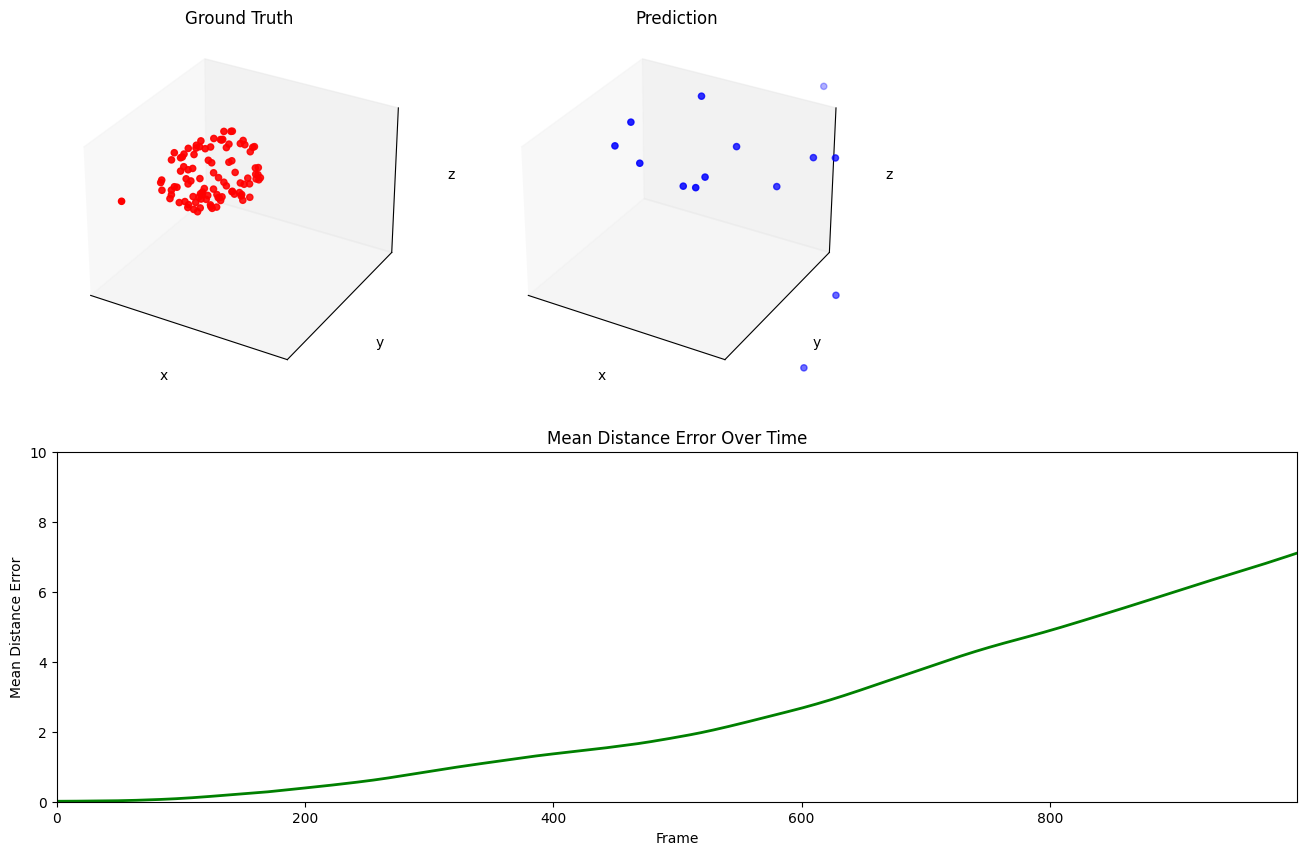

In [15]:
from datagen import generate_n_body_scene
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# animate the scene in 3d comparing the predicted scene with the actual scene
def get_new_pos_vel(acc, pos, vel, dt=0.01):
    new_vel = vel + acc * dt
    new_pos = pos + new_vel * dt
    return new_pos, new_vel

def sim_accelerations(positions, masses, G=1.0, softening=0.1):
    x = positions[:, 0:1]
    y = positions[:, 1:2]
    z = positions[:, 2:3]
    
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0]**(-1.5)
    
    ax = G * (dx * inv_r3) @ masses
    ay = G * (dy * inv_r3) @ masses
    az = G * (dz * inv_r3) @ masses

    return np.hstack((ax, ay, az))

def generate_rollout(model, scene, n_steps=1000, dt=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    masses = torch.tensor(scene['masses']).unsqueeze(-1)
    positions = torch.tensor(scene['frames'][0]['pos'])
    velocities = torch.tensor(scene['frames'][0]['vel'])
    Gs = torch.ones_like(masses)
    softening = torch.ones_like(masses) * 0.1
    features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
    graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, RADIUS)
    graph_data = graph_data.to(device)
    pos_pred = []
    acc_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            out = model(graph_data)
            acc = out.cpu().numpy()
            acc_pred.append(acc)
            new_pos, new_vel = get_new_pos_vel(acc, positions, velocities, dt=dt)
            new_feats = torch.cat([new_pos, new_vel, Gs, softening, masses], dim=-1)
            graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(new_feats, new_pos, RADIUS)
            graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
            positions = new_pos
            velocities = new_vel
            pos_pred.append(new_pos)
            graph_data = graph_data.to(device)
    return np.array(pos_pred), np.array(acc_pred)

def generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=0.5):

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    masses = torch.tensor(scene['masses']).unsqueeze(-1)
    positions = torch.tensor(scene['frames'][0]['pos'])
    velocities = torch.tensor(scene['frames'][0]['vel'])
    Gs = torch.ones_like(masses)
    softening = torch.ones_like(masses) * 0.1
    features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
    graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, RADIUS)
    graph_data = graph_data.to(device)
    pos_pred = []
    acc_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            if np.random.rand() < model_percentage:
                out = model(graph_data)
                acc = out.cpu().numpy()
            else:
                acc = sim_accelerations(positions.numpy(), masses.numpy())
            acc_pred.append(acc)
            new_pos, new_vel = get_new_pos_vel(acc, positions, velocities, dt=dt)
            new_feats = torch.cat([new_pos, new_vel, Gs, softening, masses], dim=-1)
            graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(new_feats, new_pos, RADIUS)
            graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
            positions = new_pos
            velocities = new_vel
            pos_pred.append(new_pos)
            graph_data = graph_data.to(device)
    return np.array(pos_pred), np.array(acc_pred)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch

def animate_scene(scene, pos_pred):
    # Create a 2D animation with a line plot below
    fig = plt.figure(figsize=(16, 10))

    # 3D scatter plot for Ground Truth
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(-2, 2)
    ax1.set_zlim(-2, 2)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.set_title('Ground Truth')

    # 3D scatter plot for Prediction
    ax2 = fig.add_subplot(232, projection='3d')
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_zlim(-2, 2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_title('Prediction')

    # Line plot for mean distance error over time
    ax3 = fig.add_subplot(212)
    ax3.set_xlim(0, len(pos_pred) - 1)
    ax3.set_ylim(0, 10)
    ax3.set_xlabel('Frame')
    ax3.set_ylabel('Mean Distance Error')
    ax3.set_title('Mean Distance Error Over Time')
    line, = ax3.plot([], [], color='g', lw=2)

    # Prepare the data
    n_bodies = len(scene['masses'])
    gt_pos = np.array([frame['pos'] for frame in scene['frames']])
    scat1 = ax1.scatter(gt_pos[0, :, 0], gt_pos[0, :, 1], gt_pos[0, :, 2], c='r')
    scat2 = ax2.scatter(pos_pred[0, :, 0], pos_pred[0, :, 1], pos_pred[0, :, 2], c='b')

    # Calculate mean distances for each frame
    mean_distance_per_step = [
        mean_distance(torch.tensor(pos_pred[i]), torch.tensor(gt_pos[i])).item()
        for i in range(len(pos_pred))
    ]

    # Update function for animation
    def update(frame):
        # Update 3D scatter plots
        scat1._offsets3d = (gt_pos[frame, :, 0], gt_pos[frame, :, 1], gt_pos[frame, :, 2])
        scat2._offsets3d = (pos_pred[frame, :, 0], pos_pred[frame, :, 1], pos_pred[frame, :, 2])

        # Update line plot with error values up to current frame
        line.set_data(np.arange(frame + 1), mean_distance_per_step[:frame + 1])
        
        return scat1, scat2, line

    # Create animation
    anim = FuncAnimation(fig, update, frames=len(pos_pred), blit=True, interval=10)

    return anim, mean_distance_per_step



import time

start_sim = time.time()
scene = generate_scene_1gal(particles=100)
end_sim = time.time()
print(f'Simulation time: {end_sim - start_sim:.2f}s')
start_pred = time.time()
pos_pred, acc_pred = generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=0.75)
end_pred = time.time()
print(f'Prediction time: {end_pred - start_pred:.2f}s')
ani, mean_dist = animate_scene(scene, pos_pred)
HTML(ani.to_html5_video())